In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
%matplotlib inline


In [2]:
face_cascade = cv2.CascadeClassifier("./opencv/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("./opencv/haarcascade_eye.xml")

In [3]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [4]:
path_to_data="./Datasets/"
path_to_cr_data='./Datasets/cropped/'

In [5]:
import os
img_dirs=[]
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['./Datasets/cropped',
 './Datasets/Elon Musk',
 './Datasets/Lionel Messi',
 './Datasets/Maria Sharpova',
 './Datasets/Smrithi Madhana',
 './Datasets/Virat Kohli']

In [6]:
import shutil
if os.path.exists(path_to_cr_data): #Checking if cropped folder exists
    shutil.rmtree(path_to_cr_data) #Clearing the folder for clearing old pics for multiple runs
os.mkdir(path_to_cr_data)

In [7]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count=1
    celebrity_name = img_dir.split('/')[-1]   
    
    celebrity_file_names_dict[celebrity_name]=[]
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
            
            cropped_file_name=celebrity_name+str(count)+'.png'
            cropped_file_path=cropped_folder+'/'+cropped_file_name
            
            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count +=1
                
                
    
            

In [8]:
celebrity_file_names_dict 

{'cropped': [],
 'Elon Musk': ['./Datasets/cropped/Elon Musk/Elon Musk1.png',
  './Datasets/cropped/Elon Musk/Elon Musk2.png',
  './Datasets/cropped/Elon Musk/Elon Musk3.png',
  './Datasets/cropped/Elon Musk/Elon Musk4.png',
  './Datasets/cropped/Elon Musk/Elon Musk5.png',
  './Datasets/cropped/Elon Musk/Elon Musk6.png',
  './Datasets/cropped/Elon Musk/Elon Musk7.png',
  './Datasets/cropped/Elon Musk/Elon Musk8.png',
  './Datasets/cropped/Elon Musk/Elon Musk9.png',
  './Datasets/cropped/Elon Musk/Elon Musk10.png',
  './Datasets/cropped/Elon Musk/Elon Musk11.png',
  './Datasets/cropped/Elon Musk/Elon Musk12.png',
  './Datasets/cropped/Elon Musk/Elon Musk13.png',
  './Datasets/cropped/Elon Musk/Elon Musk14.png',
  './Datasets/cropped/Elon Musk/Elon Musk15.png',
  './Datasets/cropped/Elon Musk/Elon Musk16.png',
  './Datasets/cropped/Elon Musk/Elon Musk17.png',
  './Datasets/cropped/Elon Musk/Elon Musk18.png',
  './Datasets/cropped/Elon Musk/Elon Musk19.png',
  './Datasets/cropped/Elon Mus

In [9]:
import pywt 

def w2d(img,mode='harr',level=1):
    imArray=img
    #DataType Conversion
    #Convert to grayscale
    imArray=cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert float
    imArray=np.float32(imArray)
    imArray/=255;
    #compute coefficients
    coeff=pywt.wavedec2(imArray,mode,level=level)
    #Process Coefficients
    coeffs_H=list(coeff)
    coeffs_H[0]*=0;
    
    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [10]:
class_dict={}
count=0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name]=count
    count=count+1
class_dict

{'cropped': 0,
 'Elon Musk': 1,
 'Lionel Messi': 2,
 'Maria Sharpova': 3,
 'Smrithi Madhana': 4,
 'Virat Kohli': 5}

In [11]:
X=[]
y=[]
for celebrity_name,training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img=cv2.imread(training_image)
        if img is None:
            continue 
        scalled_raw_img=cv2.resize(img,(32,32))        
        img_har=w2d(img,'db1',5)
        scalled_img_har=cv2.resize(img_har,(32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [12]:
len(X[0])

4096

In [13]:
X[0]

array([[ 94],
       [ 63],
       [ 41],
       ...,
       [ 85],
       [207],
       [200]], dtype=uint8)

In [14]:
X=np.array(X).reshape(len(X),4096).astype(float)
X.shape

(139, 4096)

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3)

pipe=Pipeline([('scaler',StandardScaler()),('svc',LogisticRegression())])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

C:\Users\sanjay\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8

In [17]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           1       0.80      0.50      0.62         8
           2       1.00      1.00      1.00         7
           3       0.60      0.75      0.67         4
           4       0.67      0.80      0.73         5
           5       0.83      0.91      0.87        11

    accuracy                           0.80        35
   macro avg       0.78      0.79      0.78        35
weighted avg       0.81      0.80      0.79        35



In [18]:
len(X_test)

35

In [19]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [20]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [21]:
scores=[]
best_estimator={}
import pandas as pd
for algo,np in model_params.items():
    pipe=make_pipeline(StandardScaler(),np['model'])
    clf=GridSearchCV(pipe,np['params'],cv=5,return_train_score=True)
    clf.fit(X_train,y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimator[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


,model,best_score,best_params
0,svm,0.701429,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.623810,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.740476,{'logisticregression__C': 1}


In [22]:
best_estimator['svm'].score(X_test,y_test)

0.8285714285714286

In [23]:
best_estimator['logistic_regression'].score(X_test,y_test)

0.8285714285714286

In [24]:
best_clf = best_estimator['svm']

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 5,  0,  1,  1,  1],
       [ 0,  7,  0,  0,  0],
       [ 1,  0,  3,  0,  0],
       [ 1,  0,  0,  4,  0],
       [ 1,  0,  0,  0, 10]], dtype=int64)

Text(69.0, 0.5, 'Truth')

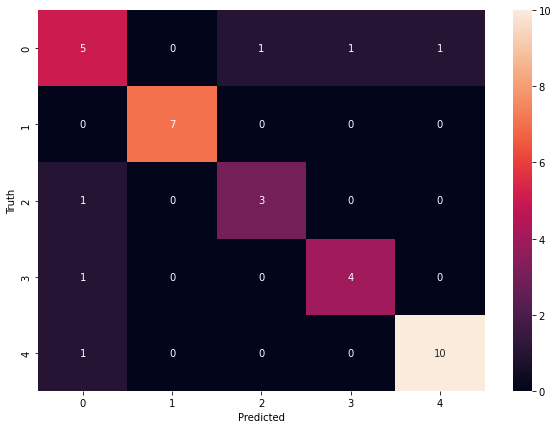

In [26]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [27]:
class_dict

{'cropped': 0,
 'Elon Musk': 1,
 'Lionel Messi': 2,
 'Maria Sharpova': 3,
 'Smrithi Madhana': 4,
 'Virat Kohli': 5}

In [28]:
import joblib
joblib.dump(best_clf,'Saved_model.pkl')

['Saved_model.pkl']

In [29]:
import json 
with open("class_dictationary.json","w") as f:
    f.write(json.dumps(class_dict))